In [ ]:
!pip install deepface

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 4.3 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 4.3 MB/s eta 0:00:004.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.3 MB/s eta 0:00:005.2 MB/s eta 0:00:01
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=ac29ea762cad9116b24e3bb515b95304a2b180763253b38e78d62965a55096bb
  Stored in directory: /home/chetan/.cache/pip/wheels/9e/5b/45/29f72e55d87a29426b04b3cfdf20325c079eb97ab74f59017d
Successfully built fire
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.3
    Uninstalling numpy-2.2.3:
      Successfully uninstalled numpy-2.2.3
  Attempting uninstall: lz4
    Found existing installation: lz4 4.3.2
    Uninstalling lz4-4.3.2:
      Successfully uninstalled lz4-4.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are 

In [ ]:
import os
import cv2
import numpy as np
import insightface
from insightface.app import FaceAnalysis
from scipy.spatial.distance import cosine
import pickle

def load_facenet_model():
    app = FaceAnalysis(name='buffalo_l', providers=['CPUExecutionProvider'])
    app.prepare(ctx_id=0, det_size=(640, 640))
    return app

def generate_embeddings(face_dir, model, save_path='embeddings.pkl'):
    embeddings = {}
    for img_name in os.listdir(face_dir):
        img_path = os.path.join(face_dir, img_name)
        img = cv2.imread(img_path)
        faces = model.get(img)
        if faces:
            embeddings[img_name] = faces[0].embedding
    with open(save_path, 'wb') as f:
        pickle.dump(embeddings, f)
    print(f"Embeddings saved to {save_path}")

def load_embeddings(path='embeddings.pkl'):
    with open(path, 'rb') as f:
        return pickle.load(f)

def detect_faces(image, model):
    faces = model.get(image)
    return faces

def match_faces(detected_faces, stored_embeddings):
    matched_faces = []
    for face in detected_faces:
        best_match = None
        best_score = float('inf')
        for name, stored_embedding in stored_embeddings.items():
            score = cosine(face.embedding, stored_embedding)
            if score < best_score:
                best_score = score
                best_match = name
        matched_faces.append((face, best_match, best_score))
    return matched_faces

def display_results(image, matched_faces):
    for face, name, score in matched_faces:
        x, y, w, h = map(int, face.bbox)
        cv2.rectangle(image, (x, y), (w, h), (0, 255, 0), 2)
        cv2.putText(image, f"{name} ({score:.2f})", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv2.imshow("Matched Faces", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def main(face_dir, sample_image_path):
    model = load_facenet_model()
    generate_embeddings(face_dir, model)
    stored_embeddings = load_embeddings()
    sample_image = cv2.imread(sample_image_path)
    detected_faces = detect_faces(sample_image, model)
    matched_faces = match_faces(detected_faces, stored_embeddings)
    display_results(sample_image, matched_faces)

# Example Usage
# main('faces_directory', 'sample.jpg')


In [ ]:
import os
import cv2
import numpy as np
from deepface import DeepFace
from scipy.spatial.distance import cosine
import pickle

def generate_embeddings(face_dir, save_path='embeddings.pkl'):
    """Generate embeddings for all faces in the directory and save them."""
    embeddings = {}
    for img_name in os.listdir(face_dir):
        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        img_path = os.path.join(face_dir, img_name)
        try:
            embedding = DeepFace.represent(img_path, model_name='Facenet512', enforce_detection=False)[0]['embedding']
            embeddings[img_name] = embedding
            print(f"Generated embedding for {img_name}")
        except Exception as e:
            print(f"Error processing {img_name}: {str(e)}")

    with open(save_path, 'wb') as f:
        pickle.dump(embeddings, f)
    print(f"Embeddings saved to {save_path}")

def load_embeddings(path='embeddings.pkl'):
    """Load saved embeddings from file."""
    try:
        with open(path, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"Embedding file {path} not found.")
        return {}

def detect_faces(image_path):
    """Detect faces in an image and return face regions and the image."""
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not read image from {image_path}")

        faces = DeepFace.extract_faces(
            img_path=image_path,
            detector_backend='retinaface',
            enforce_detection=False
        )
        return faces, image
    except Exception as e:
        print(f"Error detecting faces: {str(e)}")
        return [], None

def match_faces(detected_faces, stored_embeddings, image):
    """Match detected faces against stored embeddings."""
    matched_faces = []

    for face in detected_faces:
        try:
            # Extract the face region from the image
            face_img = face['face']

            # Generate embedding for the detected face
            face_embedding = DeepFace.represent(
                img_path=face_img,  # Pass the face image directly
                model_name='Facenet512',
                enforce_detection=False,
                detector_backend=None  # Skip detection as we already have the face
            )[0]['embedding']

            # Find the best match
            best_match = None
            best_score = float('inf')

            for name, stored_embedding in stored_embeddings.items():
                score = cosine(face_embedding, stored_embedding)
                if score < best_score:
                    best_score = score
                    best_match = name

            matched_faces.append((face, best_match, best_score))
        except Exception as e:
            print(f"Error matching face: {str(e)}")

    return matched_faces

def display_results(image, matched_faces):
    """Display the results with bounding boxes and labels."""
    if image is None or not matched_faces:
        print("No faces to display")
        return

    for face, name, score in matched_faces:
        try:
            x, y, w, h = map(int, face['facial_area'].values())
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Determine match quality label
            match_label = f"{name.split('.')[0]}"
            if score < 0.3:
                match_label += f" (Good match: {score:.2f})"
            elif score < 0.5:
                match_label += f" (Possible match: {score:.2f})"
            else:
                match_label += f" (Poor match: {score:.2f})"

            cv2.putText(image, match_label, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        except Exception as e:
            print(f"Error displaying face: {str(e)}")

    try:
        cv2.imshow("Matched Faces", image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    except Exception as e:
        print(f"Error displaying image: {str(e)}")
        # Save the image instead
        cv2.imwrite("matched_faces_result.jpg", image)
        print("Results saved to matched_faces_result.jpg")

def main(face_dir, sample_image_path):
    """Main function to run the face recognition pipeline."""
    try:
        # Check if directories and files exist
        if not os.path.exists(face_dir):
            print(f"Error: Directory {face_dir} does not exist")
            return

        if not os.path.exists(sample_image_path):
            print(f"Error: Image {sample_image_path} does not exist")
            return

        # Generate or load embeddings
        if not os.path.exists('embeddings.pkl'):
            print("Generating new embeddings...")
            generate_embeddings(face_dir)

        stored_embeddings = load_embeddings()
        if not stored_embeddings:
            print("No embeddings found or loaded. Generating new ones...")
            generate_embeddings(face_dir)
            stored_embeddings = load_embeddings()

        # Detect and match faces
        detected_faces, image = detect_faces(sample_image_path)

        if not detected_faces or image is None:
            print("No faces detected in the image or image could not be loaded")
            return

        print(f"Detected {len(detected_faces)} faces in the image")
        matched_faces = match_faces(detected_faces, stored_embeddings, image)

        # Display results
        display_results(image, matched_faces)

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    # Example Usage
    main('faces', 'sample.JPG')


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/chetan/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/chetan/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/chetan/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/home/cheta

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/chetan/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/chetan/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/chetan/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/home/cheta

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/chetan/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/chetan/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/chetan/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/home/cheta

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/chetan/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/chetan/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/chetan/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/home/cheta

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



2025-03-03 20:03:56.868595: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-03 20:03:57.084240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741012437.160748   50871 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741012437.186113   50871 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 20:03:57.380265: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
!python -c "import tensorflow as tf; print(tf.__version__)"


2025-03-03 20:06:39.484994: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-03 20:06:39.495293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741012599.506965   51203 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741012599.510257   51203 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 20:06:39.522257: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
!pip install --upgrade numpy h5py


  Using cached numpy-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 4.1 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: h5py
    Found existing installation: h5py 3.11.0
    Uninstalling h5py-3.11.0:
      Successfully uninstalled h5py-3.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mxnet 1.9.1 requires numpy<2.0.0,>1.16.0, but you have numpy 2.2.3 which is incompatible.
streamlit 1.37.1 requires pillow<11,>=7.1.0, but you have pillow 11.1.0 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have

In [ ]:
!pip install retinaface

INFO: pip is looking at multiple versions of retinaface to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of retinaface to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install retinaface==0.0.1, retinaface==0.0.2, retinaface==0.0.3, retinaface==0.0.4, retinaface==0.0.5, retinaface==0.0.6, retinaface==1.1.0 and retinaface==1.1.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    retinaface 1.1.1 depends on tensorflow==2.5.0
    retinaface 1.1.0 depends on tensorflow==2.5.0
    retinaface 0.0.6 depends on tensorflow==2.1.0
    retinaface 0.0.5 depends on tensorflow==2.1.0
    retinaface 0.0.4 depends on tensorflow==2.1.0
    retinaface 0.0.3 depends on tensorflow==2.1.0
    retinaface 0.0.2 depends on tensorflow==2.1.0
    retinaface 0.0.1 depends on tensorflow==2.1.0

To fix this you could try to:
1. 

In [ ]:
from retinaface import RetinaFace
import cv2
import matplotlib.pyplot as plt


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
img_path = "/sample.JPG"

In [ ]:
img=cv2.imread(img_path)

[ WARN:0@52.437] global loadsave.cpp:268 findDecoder imread_('/sample.JPG'): can't open/read file: check file path/integrity


In [ ]:
obj = RetinaFace.detect_faces(img_path)

NameError: name 'RetinaFace' is not defined

In [ ]:
len(obj.keys())

50

In [ ]:
for key in obj.keys():
  identity=obj[key]
  facial_area= identity["facial_area"]

  cv2.rectangle(img, (facial_area[2],facial_area[3]),(facial_area[0],facial_area[1]), (255,255,255), 2)

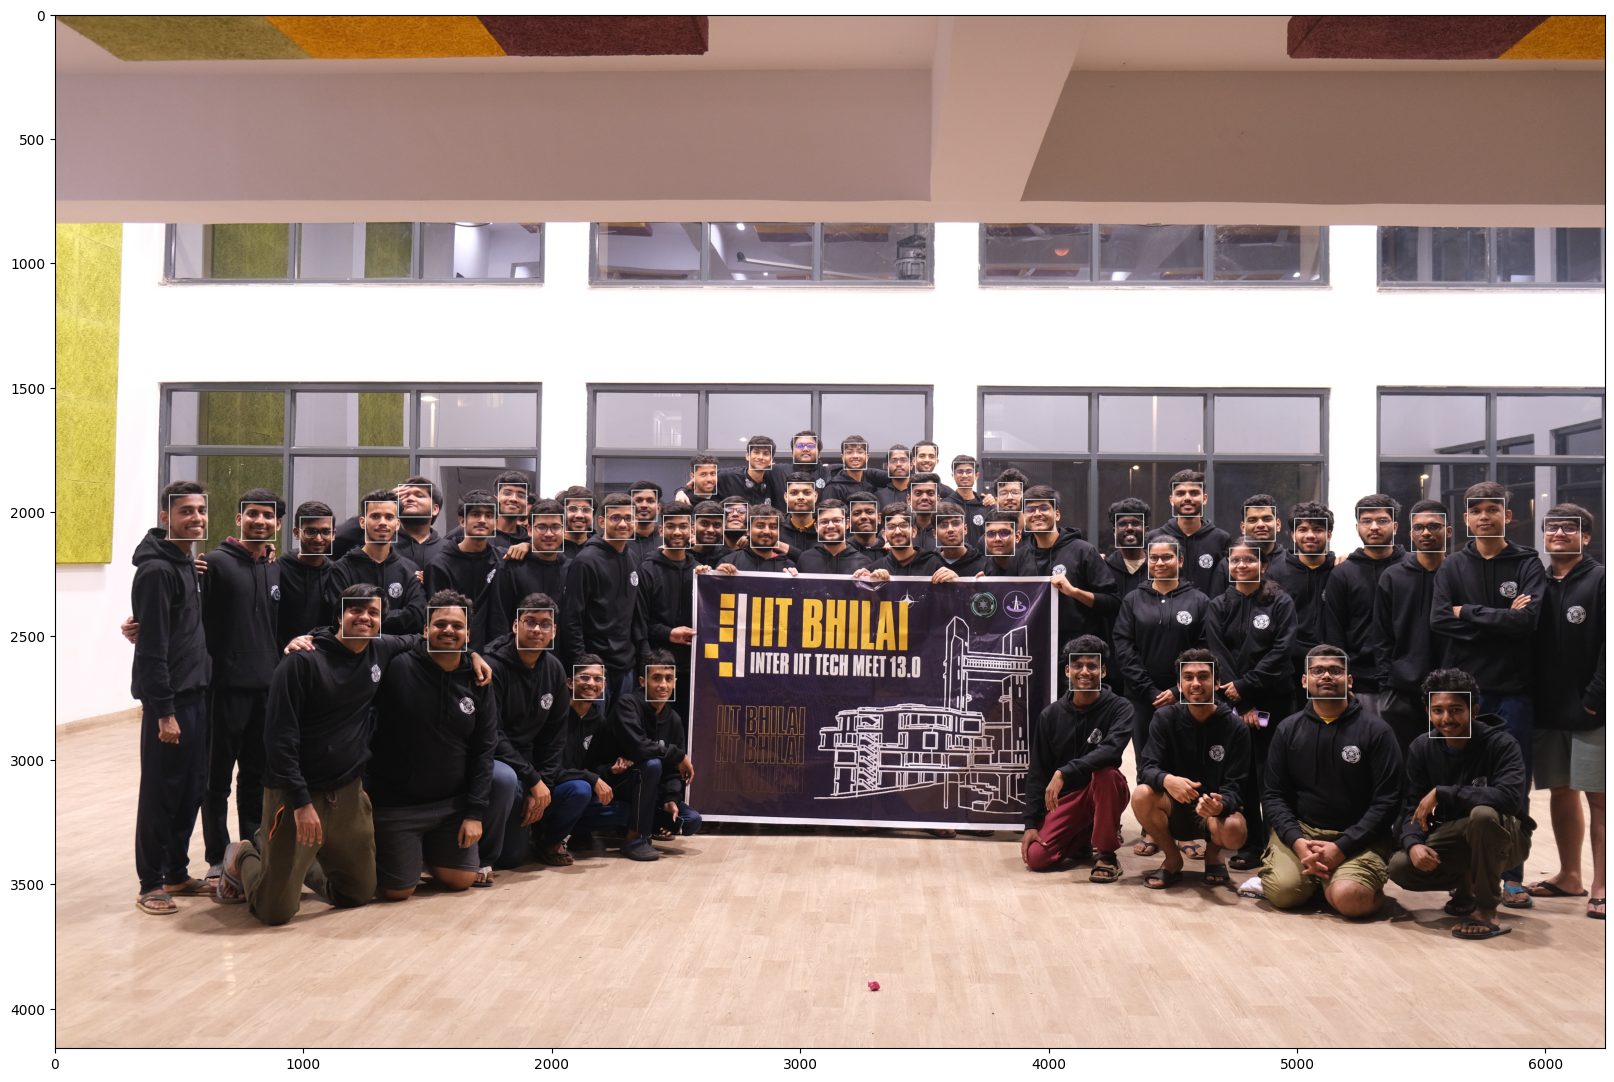

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(img[:,: , ::-1])
plt.show()

In [ ]:
import os
import numpy as np
from deepface import DeepFace
import cv2

# Define folder paths
IMAGE_FOLDER = "/content/faces"  # Change to your folder path
EMBEDDINGS_PATH = "/content/embeddings/face_embeddings.npz"

# Ensure output directory exists
os.makedirs(os.path.dirname(EMBEDDINGS_PATH), exist_ok=True)

def process_images(image_folder):
    embeddings = {}

    for filename in os.listdir(image_folder):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        person_name = os.path.splitext(filename)[0]
        image_path = os.path.join(image_folder, filename)

        try:
            # Read image to ensure it's not corrupted
            img = cv2.imread(image_path)
            if img is None:
                print(f"⚠️ Skipping {filename}: Unable to read image")
                continue

            # Extract embedding
            embedding_data = DeepFace.represent(img_path=image_path, model_name="Facenet", enforce_detection=False)
            if not embedding_data:
                print(f"⚠️ Skipping {filename}: No face detected")
                continue

            embedding = embedding_data[0]['embedding']
            embeddings[person_name] = embedding
            print(f"✅ Processed: {filename}")

            # Save embeddings incrementally to avoid memory overload
            np.savez_compressed(EMBEDDINGS_PATH, **embeddings)

        except Exception as e:
            print(f"⚠️ Error processing {filename}: {e}")

    print(f"✅ Embeddings saved at {EMBEDDINGS_PATH}")
    return embeddings

# Run processing
embeddings = process_images(IMAGE_FOLDER)


✅ Processed: img1.jpg


In [ ]:
import os
import numpy as np
from deepface import DeepFace
from scipy.spatial.distance import cosine
import cv2
from google.colab.patches import cv2_imshow  # Import cv2_imshow

# Define paths
EMBEDDINGS_PATH = "/content/embeddings/face_embeddings.npz"  # Path to stored embeddings
INPUT_IMAGE = "/content/sample.JPG"  # Change to the test image path
IMAGES_DIR = "/content/faces"  # Directory containing individual images

# ✅ Step 1: Load stored embeddings
if not os.path.exists(EMBEDDINGS_PATH):
    raise FileNotFoundError(f"❌ Embeddings file not found at {EMBEDDINGS_PATH}")

data = np.load(EMBEDDINGS_PATH)
embeddings_dict = {name: data[name] for name in data.files}

# ✅ Step 2: Extract embedding of input image
try:
    input_embedding = DeepFace.represent(img_path=INPUT_IMAGE, model_name="Facenet", enforce_detection=False)[0]['embedding']
except Exception as e:
    raise RuntimeError(f"❌ Failed to extract embedding from input image: {e}")

# ✅ Step 3: Compute similarity scores
scores = {}

for person, stored_embedding in embeddings_dict.items():
    similarity = 1 - cosine(input_embedding, stored_embedding)
    scores[person] = similarity

# ✅ Step 4: Find the best match
best_match = max(scores, key=scores.get)
best_score = scores[best_match]

# ✅ Step 5: Display results
print("\n🔍 *Similarity Scores:*")
for person, score in scores.items():
    print(f"{person}: {score:.4f}")

print(f"\n🎯 Best Match: {best_match} with similarity score {best_score:.4f}")

# ✅ Step 6: Display the image of the matched person
matched_image_path = os.path.join(IMAGES_DIR, f"{best_match}.jpg")  # Assuming images are named after the person
if os.path.exists(matched_image_path):
    matched_image = cv2.imread(matched_image_path)
    if matched_image is not None:
        cv2_imshow(matched_image)  # Use cv2_imshow instead of cv2.imshow
    else:
        print(f"❌ Failed to read the image for {best_match}.")
else:
    print(f"❌ Image for {best_match} not found at {matched_image_path}.")

# ✅ Step 3: Compute similarity scores
scores = {}

for person, stored_embedding in embeddings_dict.items():
    similarity = 1 - cosine(input_embedding, stored_embedding)
    scores[person] = similarity

# ✅ Step 4: Find the best match
best_match = max(scores, key=scores.get)
best_score = scores[best_match]

# ✅ Step 5: Display results
print("\n🔍 *Similarity Scores:*")
for person, score in scores.items():
    print(f"{person}: {score:.4f}")

print(f"\n🎯 Best Match: {best_match} with similarity score {best_score:.4f}")

# ✅ Step 6: Display the image of the matched person
matched_image_path = os.path.join(IMAGES_DIR, f"{best_match}.jpg")  # Assuming images are named after the person
if os.path.exists(matched_image_path):
    matched_image = cv2.imread(matched_image_path)
    if matched_image is not None:
        cv2_imshow(matched_image)  # Use cv2_imshow instead of cv2.imshow
    else:
        print(f"❌ Failed to read the image for {best_match}.")
else:
    print(f"❌ Image for {best_match} not found at {matched_image_path}.")


In [ ]:
import os
import numpy as np
from deepface import DeepFace
from scipy.spatial.distance import cosine
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# Define paths
EMBEDDINGS_PATH = "/content/embeddings/face_embeddings.npz"  # Path to stored embeddings
INPUT_IMAGE = "/content/sample.JPG"  # Change to the test image path
IMAGES_DIR = "/content/faces"  # Directory containing individual images

# ✅ Step 1: Load stored embeddings
if not os.path.exists(EMBEDDINGS_PATH):
    raise FileNotFoundError(f"❌ Embeddings file not found at {EMBEDDINGS_PATH}")

data = np.load(EMBEDDINGS_PATH)
embeddings_dict = {name: data[name] for name in data.files}
print(f"✅ Loaded embeddings for {len(embeddings_dict)} faces")

# ✅ Step 2: Detect faces in the input image using RetinaFace
try:
    # Read the input image
    image = cv2.imread(INPUT_IMAGE)
    if image is None:
        raise ValueError(f"❌ Could not read image from {INPUT_IMAGE}")

    # Detect faces
    detected_faces = DeepFace.extract_faces(
        img_path=INPUT_IMAGE,
        detector_backend="retinaface",
        enforce_detection=False,
        align=True
    )

    print(f"✅ Detected {len(detected_faces)} faces in the input image")

except Exception as e:
    raise RuntimeError(f"❌ Failed to detect faces in the input image: {e}")

# ✅ Step 3: Process each detected face
results = []

for i, face_data in enumerate(detected_faces):
    try:
        # Get the face image
        face_img = face_data["face"]

        # Extract embedding for this face
        face_embedding = DeepFace.represent(
            img_path=face_img,  # Pass the face image directly
            model_name="Facenet",
            enforce_detection=False,
            detector_backend=None  # Skip detection as we already have the face
        )[0]['embedding']

        # Compute similarity with all stored embeddings
        scores = {}
        for person, stored_embedding in embeddings_dict.items():
            similarity = 1 - cosine(face_embedding, stored_embedding)
            scores[person] = similarity

        # Find the best match
        best_match = max(scores, key=scores.get)
        best_score = scores[best_match]

        # Store the results
        face_location = face_data["facial_area"]
        results.append({
            "face_id": i + 1,
            "face_img": face_img,
            "location": face_location,
            "best_match": best_match,
            "best_score": best_score,
            "all_scores": scores
        })

    except Exception as e:
        print(f"❌ Error processing face #{i+1}: {e}")

# ✅ Step 4: Display results
# Create a copy of the original image for drawing
display_img = cv2.imread(INPUT_IMAGE)

for result in results:
    # Get face location
    face_id = result["face_id"]
    face_loc = result["location"]
    x, y, w, h = face_loc["x"], face_loc["y"], face_loc["w"], face_loc["h"]

    # Get match info
    match_name = result["best_match"]
    match_score = result["best_score"]

    # Draw rectangle around face
    color = (0, 255, 0) if match_score > 0.5 else (0, 165, 255)  # Green if good match, orange if poor
    cv2.rectangle(display_img, (x, y), (x+w, y+h), color, 2)

    # Add text with match info
    label = f"{match_name}: {match_score:.2f}"
    cv2.putText(display_img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Print detailed results
    print(f"\n👤 Face #{face_id}:")
    print(f"  🎯 Best Match: {match_name} with similarity score {match_score:.4f}")

    print(f"  🔍 Top 3 Similarity Scores:")
    sorted_scores = sorted(result["all_scores"].items(), key=lambda x: x[1], reverse=True)
    for person, score in sorted_scores[:3]:
        print(f"    - {person}: {score:.4f}")

# Display the image with annotations
cv2_imshow(display_img)

# ✅ Step 5: Show a grid of faces with their matches
plt.figure(figsize=(15, 5 * (len(results) + 1) // 2))

for i, result in enumerate(results):
    face_img = result["face_img"]
    match_name = result["best_match"]
    match_score = result["best_score"]

    # Display detected face
    plt.subplot(len(results), 2, i*2+1)
    plt.imshow(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected Face #{i+1}")
    plt.axis('off')

    # Display best match face from database
    match_img_path = os.path.join(IMAGES_DIR, f"{match_name}.jpg")
    if os.path.exists(match_img_path):
        match_img = cv2.imread(match_img_path)
        plt.subplot(len(results), 2, i*2+2)
        plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Best Match: {match_name}\nScore: {match_score:.4f}")
        plt.axis('off')
    else:
        plt.subplot(len(results), 2, i*2+2)
        plt.text(0.5, 0.5, f"Image not found:\n{match_name}", ha='center', va='center')
        plt.title(f"Best Match (Score: {match_score:.4f})")
        plt.axis('off')

plt.tight_layout()
plt.show()

✅ Loaded embeddings for 1 faces
